# Malaria transmission process modeling with climate variable inputs

### Import libraries

In [123]:
import pandas as pd
from models.R0_model import *
from utils.plotting import plot_ensembles


## Define malaria model default parameters

In [1]:
params = {
    "rainfall_multiplier" : 1.0, # rainfall to mosquito linear multiplication factor (per day)
    "rainfall_offset" : 0.0, # rainfall to mosquito offset
    "c" : 1.0, # inoculation effiency for mosquitoes
    "b": 0.5, # inoculation efficiency for humans
    "hbi" : 0.5, # human blood index
    "r" : 0.0284, # human recovery rate (per day)
    "hia" : 15.0, # number of days after infection when humans become infectious
    "Tg" : 9.0, #  Gonotrophic threshold temperature 
    "Dg" : 37.0, # Gonotrophic cycle length in degree days
    "Ts" : 18.0, # Sporogonic threshold temperature 
    "Ds" : 111.0, # Sporoogonic cycle length in degree days
    "stype" : 0 # Survival type (valid values are 0 = Martens, 2 = Craig)
}

## Load climate forecast ensembles

In [21]:
dataset = 'forecasts_rain-temp_Nairobi_2017-2021.csv'

In [32]:
df = pd.read_csv('datasets/'+dataset)
df.head()

,forecast,precip,temp,datetime
0,1,0.576628,17.865900,2017-01-01
1,1,0.166432,18.287195,2018-01-01
2,1,1.760069,19.013910,2019-01-01
3,1,0.000000,16.801691,2020-01-01
4,1,0.950271,17.495355,2021-01-01


In [33]:
def preprocess(data):
    
    data['datetime'] = pd.to_datetime(data['datetime'])
    data['year'] = data['datetime'].dt.year.astype(int)
    data['month'] = data['datetime'].dt.month.astype(int)
    data['day_of_month'] = data['datetime'].dt.day.astype(int)
    data['day_of_year'] = data['datetime'].dt.dayofyear.astype(int)
    data['season'] = np.where(data['month'].between(1, 6),"Spring","Fall")
    
    return data

In [34]:
df = preprocess(df)
df.tail()

,forecast,precip,temp,datetime,year,month,day_of_month,day_of_year,season
91295,50,0.000000,16.260675,2017-12-31,2017,12,31,365,Fall
91296,50,2.108539,19.631158,2018-12-31,2018,12,31,365,Fall
91297,50,23.831091,14.834802,2019-12-31,2019,12,31,365,Fall
91298,50,0.000000,21.807184,2020-12-31,2020,12,31,366,Fall
91299,50,6.121696,18.742517,2021-12-31,2021,12,31,365,Fall


## Calculate the components of R0
### (1) Calculate mosquito population survival per day

In [35]:
df['P'] = mos_survival(params['stype'], df['temp'].values)
df.head()

,forecast,precip,temp,datetime,year,month,day_of_month,day_of_year,season,P
0,1,0.576628,17.865900,2017-01-01,2017,1,1,1,Spring,0.904054
1,1,0.166432,18.287195,2018-01-01,2018,1,1,1,Spring,0.902434
2,1,1.760069,19.013910,2019-01-01,2019,1,1,1,Spring,0.898305
3,1,0.000000,16.801691,2020-01-01,2020,1,1,1,Spring,0.905616
4,1,0.950271,17.495355,2021-01-01,2021,1,1,1,Spring,0.905009


### (2) Calculate gonotrophic and sporogonic cycle lengths

In [36]:
df['gono_len'] = gono_length(df['temp'].values, params['Dg'], params['Tg'])
df.head()

,forecast,precip,temp,datetime,year,month,day_of_month,day_of_year,season,P,gono_len
0,1,0.576628,17.865900,2017-01-01,2017,1,1,1,Spring,0.904054,5.173293
1,1,0.166432,18.287195,2018-01-01,2018,1,1,1,Spring,0.902434,4.983980
2,1,1.760069,19.013910,2019-01-01,2019,1,1,1,Spring,0.898305,4.694860
3,1,0.000000,16.801691,2020-01-01,2020,1,1,1,Spring,0.905616,5.742562
4,1,0.950271,17.495355,2021-01-01,2021,1,1,1,Spring,0.905009,5.355321


In [37]:
df['sporo_len'] = sporo_length(df['temp'].values, params['Ds'], params['Ts'])
df.head()

,forecast,precip,temp,datetime,year,month,day_of_month,day_of_year,season,P,gono_len,sporo_len
0,1,0.576628,17.865900,2017-01-01,2017,1,1,1,Spring,0.904054,5.173293,1000.000000
1,1,0.166432,18.287195,2018-01-01,2018,1,1,1,Spring,0.902434,4.983980,386.497216
2,1,1.760069,19.013910,2019-01-01,2019,1,1,1,Spring,0.898305,4.694860,109.477182
3,1,0.000000,16.801691,2020-01-01,2020,1,1,1,Spring,0.905616,5.742562,1000.000000
4,1,0.950271,17.495355,2021-01-01,2021,1,1,1,Spring,0.905009,5.355321,1000.000000


### (3) Calculate the mosquito population and combine all of the above factors to obtain R0

In [120]:
df_mospop = pd.DataFrame()
for iyear in df['year'].unique():
    data_yearly = df[df['year']==iyear].copy()
    for iseason in data_yearly['season'].unique():
        data_seasonal = data_yearly[data_yearly['season']==iseason].copy()
        for iforecast in data_seasonal['forecast'].unique():
            df_curr = data_seasonal[data_seasonal['forecast']==iforecast]
            p_array = df_curr['P'].values.reshape((1,1,len(df_curr)))
            r_array = df_curr['precip'].values.reshape((1,1,len(df_curr)))
            g_array = df_curr['gono_len'].values.reshape((1,1,len(df_curr)))
            s_array = df_curr['sporo_len'].values.reshape((1,1,len(df_curr)))
            d_array = df_curr['day_of_year'].values.reshape((1,1,len(df_curr)))
            m_array = calc_mosquito_pop(0.0, p_array, r_array, 1, params["rainfall_multiplier"], params["rainfall_offset"])
            R0 = calculate_R0(m_array, p_array, g_array, s_array, params["r"], \
                             params["hia"], params["hbi"], params["b"], params["c"])
            df_mospop_curr = pd.DataFrame(np.array([
                                            #d_array.reshape(len(df_curr)).astype(int),
                                            m_array.reshape(len(df_curr)),
                                            R0.reshape(len(df_curr))]
                                            ).T, 
                                          columns=['mosquitoes', 'R0'])
            df_mospop_curr['year'] = iyear.astype(int)
            df_mospop_curr['season'] = iseason
            df_mospop_curr['forecast'] = iforecast.astype(int)
            df_mospop_curr['day_of_year'] = df_curr['day_of_year'].values
            df_mospop = pd.concat([df_mospop, df_mospop_curr], ignore_index=True)
df = pd.merge(df, df_mospop, on=['year', 'season', 'forecast', 'day_of_year'], how='left')
df

,forecast,precip,temp,datetime,year,month,day_of_month,day_of_year,season,P,gono_len,sporo_len,mosquitoes,R0
0,1,0.576628,17.865900,2017-01-01,2017,1,1,1,Spring,0.904054,5.173293,1000.000000,0.000000,0.000000e+00
1,1,0.166432,18.287195,2018-01-01,2018,1,1,1,Spring,0.902434,4.983980,386.497216,0.000000,0.000000e+00
2,1,1.760069,19.013910,2019-01-01,2019,1,1,1,Spring,0.898305,4.694860,109.477182,0.000000,0.000000e+00
3,1,0.000000,16.801691,2020-01-01,2020,1,1,1,Spring,0.905616,5.742562,1000.000000,0.000000,0.000000e+00
4,1,0.950271,17.495355,2021-01-01,2021,1,1,1,Spring,0.905009,5.355321,1000.000000,0.000000,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91295,50,0.000000,16.260675,2017-12-31,2017,12,31,365,Fall,0.905021,6.095945,1000.000000,32.306927,1.141342e-42
91296,50,2.108539,19.631158,2018-12-31,2018,12,31,365,Fall,0.893471,4.480336,68.049796,14.022683,8.358339e-03
91297,50,23.831091,14.834802,2019-12-31,2019,12,31,365,Fall,0.898965,7.341260,1000.000000,19.118897,5.296203e-46
91298,50,0.000000,21.807184,2020-12-31,2020,12,31,366,Fall,0.866703,3.889004,29.155408,2.806308,5.755773e-02


In [241]:
df.to_csv('datasets/forecasts_R0-malaria-model-variables.csv', index=False)

## Visual dataset exploration

In [9]:
# Load dataset
df = pd.read_csv('datasets/forecasts_R0-malaria-model-variables.csv')

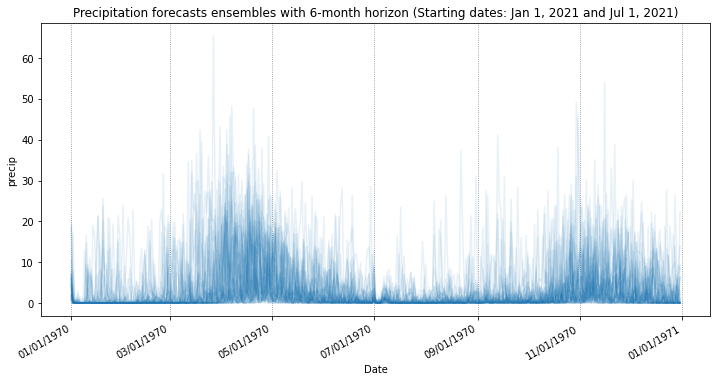

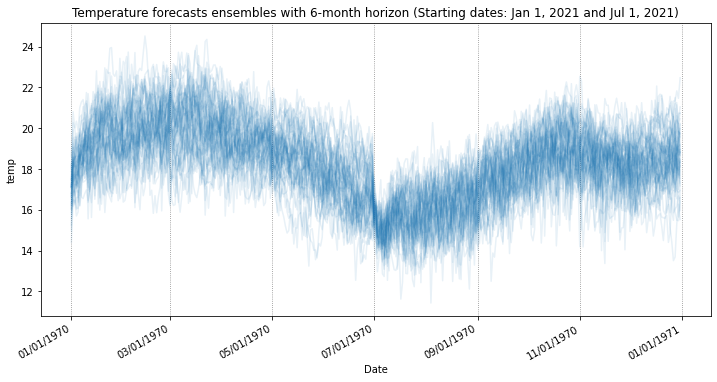

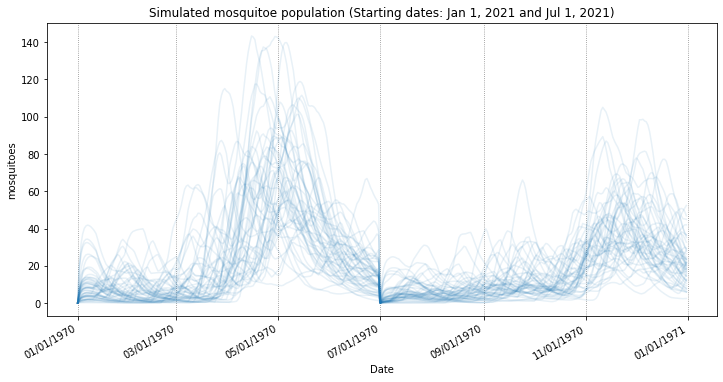

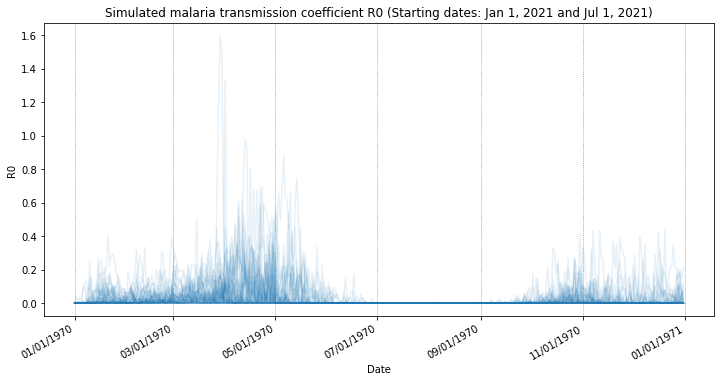

In [11]:
year = 2021
df_plot = df[df['year']==year].copy()
plot_ensembles(df_plot, 'precip', 'Precipitation forecasts ensembles with 6-month horizon (Starting dates: Jan 1, '+str(year)+' and Jul 1, '+str(year)+')', figname='precipitation_'+str(year)+'.png')
plot_ensembles(df_plot, 'temp', 'Temperature forecasts ensembles with 6-month horizon (Starting dates: Jan 1, '+str(year)+' and Jul 1, '+str(year)+')', figname='temperature_'+str(year)+'.png')
plot_ensembles(df_plot, 'mosquitoes', 'Simulated mosquitoe population (Starting dates: Jan 1, '+str(year)+' and Jul 1, '+str(year)+')')
plot_ensembles(df_plot, 'R0', 'Simulated malaria transmission coefficient R0 (Starting dates: Jan 1, '+str(year)+' and Jul 1, '+str(year)+')', figname='R0_'+str(year)+'.png')